In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
words = open('names.txt','r').read().splitlines()
words[:9]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper']

In [12]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [42]:
block_size = 3
def build_dataset(words):
    
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context),'---->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [43]:
n_embed = 10
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / (n_embed * block_size ** 0.5)
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.ones((1, n_hidden))
bnmeanrunning = torch.zeros((1, n_hidden))
bnstdrunning = torch.ones((1, n_hidden))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

In [45]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):    

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    
    with torch.no_grad():
        bnmeanrunning = 0.999 * bnmeanrunning + 0.001 * bnmeani
        bnstdrunning = 0.999 * bnstdrunning + 0.001 * bnstdi
        
    hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
# print(loss.item())
    # break


      0/ 200000: 3.3056
  10000/ 200000: 2.2686
  20000/ 200000: 2.2901
  30000/ 200000: 2.3831
  40000/ 200000: 2.3318
  50000/ 200000: 1.9630
  60000/ 200000: 2.3741
  70000/ 200000: 2.4058
  80000/ 200000: 1.9711
  90000/ 200000: 2.0026
 100000/ 200000: 2.0902
 110000/ 200000: 2.3764
 120000/ 200000: 2.3093
 130000/ 200000: 1.9646
 140000/ 200000: 2.0804
 150000/ 200000: 2.1960
 160000/ 200000: 1.5733
 170000/ 200000: 2.4649
 180000/ 200000: 2.2057
 190000/ 200000: 2.0235


In [32]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 100])

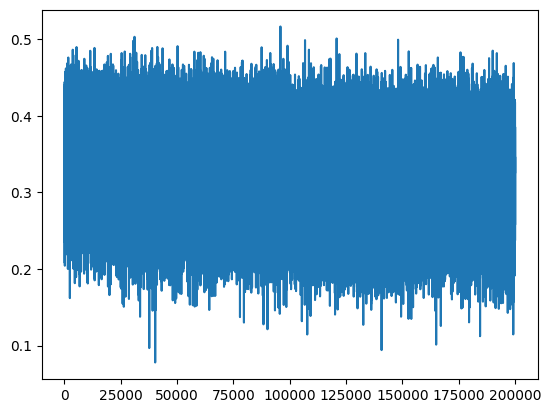

In [21]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x, y = {'train': (Xtr, Ytr),
            'val': (Xdev, Ydev),
            'test': (Xte, Yte)
            }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * ((hpreact - bnmeanrunning) / bnstdrunning) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1055803298950195
val 2.1480982303619385


In [22]:
split_loss('train')
split_loss('val')

train 2.0886218547821045
val 2.1307106018066406


In [11]:
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, emb.shape[1] * emb.shape[2]) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix==0:
            break
    print(''.join(itos[i] for i in out))


mon.
ammyanniee.
med.
ryal.
rethrelendrari.
adered.
eliigh.
piopareiel.
san.
nar.
kayzion.
kamin.
shubtrishiriel.
kin.
reneliph.
terian.
bamarda.
jylene.
elsyn.
ajaysenyan.


In [94]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2347483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


46497


In [95]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3198


layer 1 (      Tanh): mean +0.02, std 0.76, saturated: 19.41%
layer 3 (      Tanh): mean +0.01, std 0.72, saturated: 12.97%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 14.06%
layer 7 (      Tanh): mean -0.00, std 0.73, saturated: 10.59%
layer 9 (      Tanh): mean +0.03, std 0.70, saturated: 9.72%


Text(0.5, 1.0, 'activation distribution')

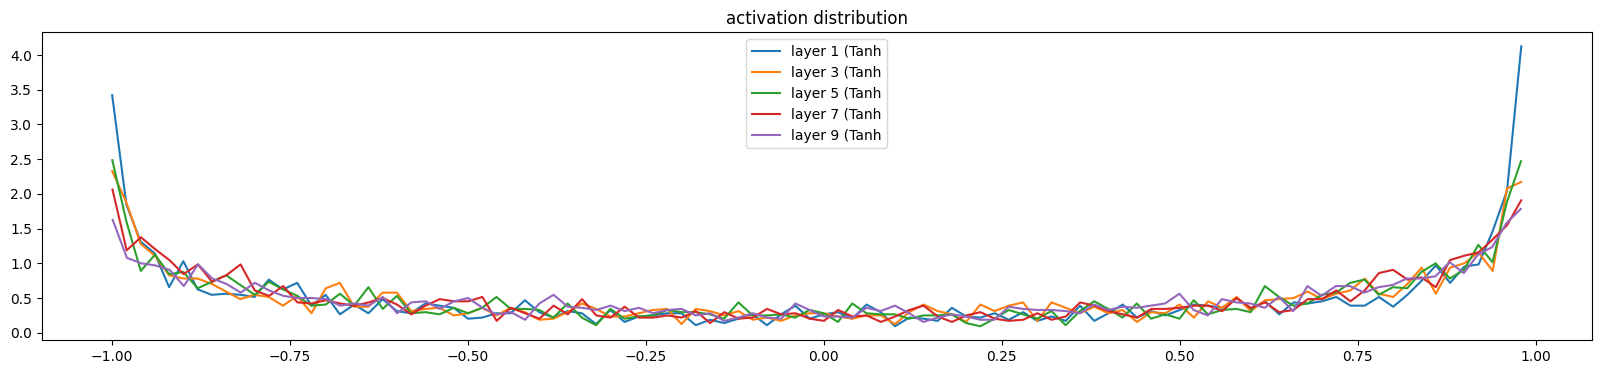

In [96]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000081, std 2.926373e-03
layer 3 (      Tanh): mean -0.000079, std 2.866092e-03
layer 5 (      Tanh): mean -0.000128, std 2.756146e-03
layer 7 (      Tanh): mean +0.000044, std 2.666184e-03
layer 9 (      Tanh): mean -0.000024, std 2.214580e-03


Text(0.5, 1.0, 'gradient distribution')

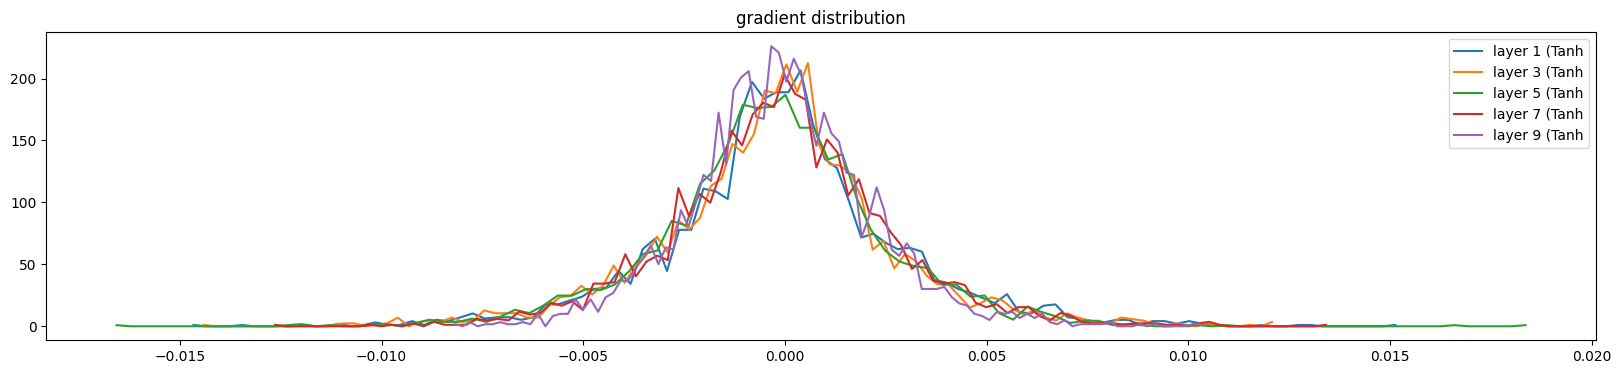

In [76]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000345 | std 9.937539e-03 | grad:data ratio 1.055365e-02
weight  (30, 100) | mean -0.000064 | std 8.244918e-03 | grad:data ratio 2.725310e-02
weight (100, 100) | mean +0.000059 | std 7.026650e-03 | grad:data ratio 4.208431e-02
weight (100, 100) | mean -0.000097 | std 6.489937e-03 | grad:data ratio 3.871240e-02
weight (100, 100) | mean -0.000043 | std 6.258430e-03 | grad:data ratio 3.730966e-02
weight (100, 100) | mean -0.000053 | std 5.079916e-03 | grad:data ratio 2.991851e-02
weight  (100, 27) | mean +0.000000 | std 2.410412e-02 | grad:data ratio 3.415135e-01


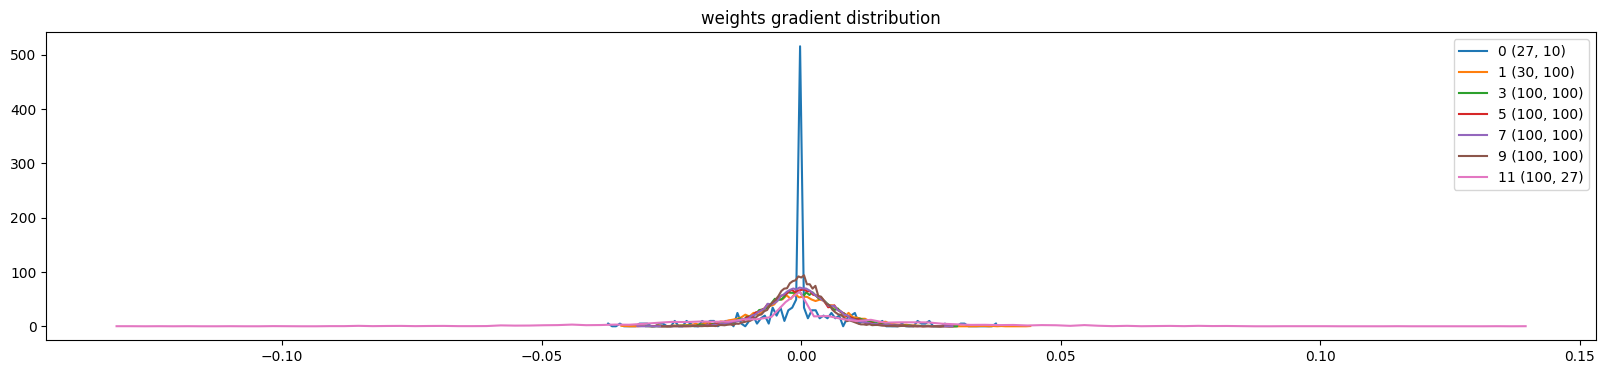

In [77]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

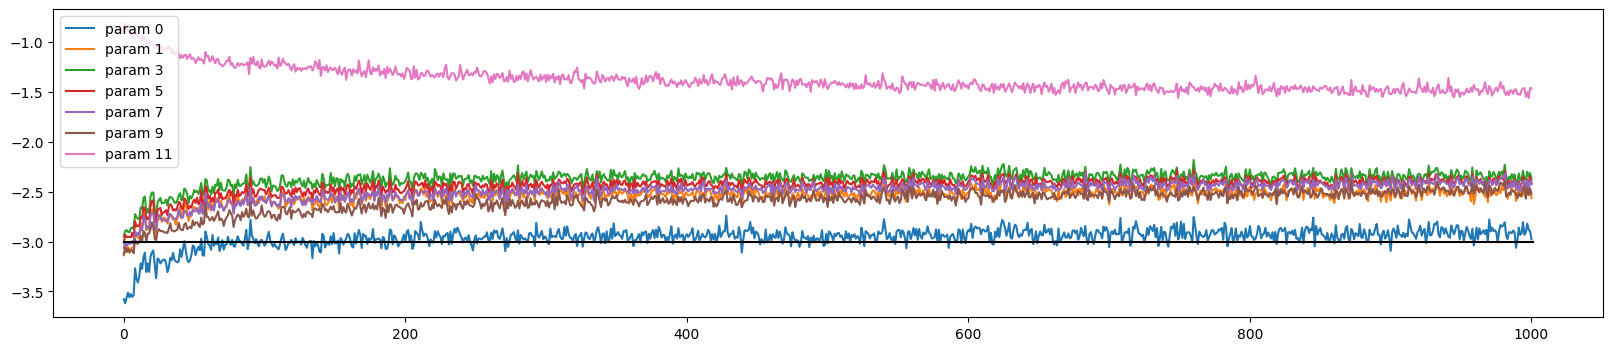

In [78]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [87]:
layers[1].out.grad

tensor([[ 2.7977e-03,  8.7851e-04,  7.5573e-04,  ..., -2.7103e-03,
         -5.8144e-04, -2.9437e-03],
        [ 1.4172e-03,  1.4950e-03,  8.5755e-04,  ..., -4.6661e-03,
          1.1340e-04, -9.0408e-04],
        [-8.3732e-04, -8.3020e-04,  2.0417e-03,  ...,  3.2330e-03,
          2.5408e-03, -8.5565e-04],
        ...,
        [-9.5210e-04, -1.7604e-04,  6.8765e-04,  ..., -9.3809e-04,
         -4.8327e-04, -7.0272e-05],
        [ 2.3817e-03, -1.4569e-03,  8.4293e-03,  ...,  1.4524e-03,
          2.8534e-03,  4.8138e-03],
        [ 6.8068e-03,  5.9191e-03,  3.4792e-03,  ..., -4.6319e-03,
         -2.8199e-03,  4.5440e-05]])